In [ ]:
#default_exp postproc

# Postprocessing

> Smoothing, combining etc.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from pathlib import Path
import os
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, box, shape
import numpy as np
from itertools import product
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt

## Math

In [ ]:
# export

def poly_IoU(poly_1:Polygon, poly_2:Polygon) -> float:
    "IoU for polygons"
    area_intersection = poly_1.intersection(poly_2).area
    area_union = poly_1.union(poly_2).area
    iou = area_intersection / area_union
    return iou

def poly_intersection_over_area(poly_1:Polygon, poly_2:Polygon) -> float:
    "How much of smaller polygon is contained within larger"
    if poly_1.area > poly_2.area: 
        smaller = poly_2
        larger = poly_1
    else: 
        smaller = poly_1
        larger = poly_2
    area_intersection = larger.intersection(smaller).area
    intersection_over_area = area_intersection / smaller.area
    return intersection_over_area

In [ ]:
test_data = gpd.read_file('../../drone-tree-detection/test_preds.shp')

In [ ]:
fallen = test_data[test_data.label == 2]
fallen.reset_index(inplace=True)

In [ ]:
inters_dict = {}
for i, row in fallen.iterrows():
    if any(fallen.geometry.intersects(row.geometry)): 
        inters_dict[i] = fallen[fallen.geometry.intersects(row.geometry)].index.tolist()
        inters_dict[i].remove(i)
    

In [ ]:
fallen[fallen.geometry.intersects(row.geometry)].index.tolist()

[506, 508, 524, 656, 657]

In [ ]:
poly_IoU(fallen.iloc[1].geometry, fallen.iloc[33].geometry)

0.8055883510503123

In [ ]:
poly_intersection_over_area(fallen.iloc[33].geometry, fallen.iloc[1].geometry)

0.9420156465508968

<AxesSubplot:>

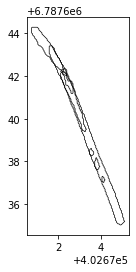

In [ ]:
fallen.iloc[[28,11,32,37,38,39,40]].plot(facecolor='none', edgecolor='black', lw=0.7)

In [ ]:
fallen.iloc[44].geometry.intersects(fallen.iloc[0].geometry)

True

In [ ]:
inters_dict

{0: [44, 45],
 1: [33],
 2: [43, 528, 551],
 3: [23],
 4: [43],
 5: [34, 43],
 6: [14, 35, 36, 43],
 7: [553, 555],
 8: [],
 9: [46],
 10: [18, 24, 29, 30],
 11: [27, 28, 32, 37],
 12: [],
 13: [],
 14: [6, 35, 36],
 15: [],
 16: [],
 17: [],
 18: [10, 24],
 19: [],
 20: [41],
 21: [42],
 22: [41, 42],
 23: [3],
 24: [10, 18, 29, 30],
 25: [],
 26: [],
 27: [11, 32],
 28: [11, 32, 37, 38, 39, 40],
 29: [10, 24],
 30: [10, 24],
 31: [],
 32: [11, 27, 28, 37],
 33: [1],
 34: [5, 43],
 35: [6, 14],
 36: [6, 14],
 37: [11, 28, 32],
 38: [28],
 39: [28],
 40: [28],
 41: [20, 22],
 42: [21, 22],
 43: [2, 4, 5, 6, 34, 528, 551],
 44: [0],
 45: [0],
 46: [9],
 47: [],
 48: [],
 49: [],
 50: [56, 61, 63, 64, 69, 113],
 51: [62, 112],
 52: [110, 115],
 53: [66, 69],
 54: [70],
 55: [],
 56: [50, 61, 63, 64, 69, 113],
 57: [60, 68],
 58: [60, 68],
 59: [],
 60: [57, 58, 68],
 61: [50, 56],
 62: [51, 112],
 63: [50, 56, 113],
 64: [50, 56, 69, 113],
 65: [69],
 66: [53, 69],
 67: [],
 68: [57, 58,

# Vector shapefile postprocessing

Steps in postprocessing:
1. Drop all polygons that are within another polygon of a same class
2. Merge all polygons of a same class that have IoU / IoA larger than (p1.union(p2))

In [ ]:
iswithin = []
for i, row in fallen.iterrows():
    within = fallen[fallen.geometry.contains(row.geometry)].index.tolist()
    within.remove(i)
    if len(within) > 0: iswithin.append(1)
    else: iswithin.append(0)

In [ ]:
fallen['is_within'] = iswithin

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
fallen.is_within.value_counts()

0    574
1     84
Name: is_within, dtype: int64

In [ ]:
fallen = fallen[fallen.is_within == 0]
fallen.reset_index(inplace=True, drop=True)

In [ ]:
fallen.to_file('../../drone-tree-detection/within_removed.shp')

In [ ]:
fallen.iloc[i+1:].geometry

1      POLYGON ((402671.653 6787656.170, 402671.629 6...
2      POLYGON ((402668.209 6787655.540, 402668.185 6...
3      POLYGON ((402670.877 6787653.988, 402670.853 6...
4      POLYGON ((402670.586 6787652.581, 402670.562 6...
5      POLYGON ((402675.534 6787646.275, 402675.510 6...
                             ...                        
576    POLYGON ((402679.463 6787745.666, 402679.414 6...
577    POLYGON ((402380.077 6787926.743, 402380.053 6...
578    POLYGON ((402381.921 6787926.694, 402381.872 6...
579    POLYGON ((402385.316 6787931.594, 402385.268 6...
580    POLYGON ((402385.365 6787931.594, 402385.316 6...
Name: geometry, Length: 580, dtype: geometry

In [ ]:
fallen.iloc[i+1:][fallen.iloc[(i+1):].geometry.intersects(row.geometry)]

,index,label,geometry,is_within
24,36,2,"POLYGON ((402661.515 6787635.167, 402661.467 6...",0


In [ ]:
new_geoms = []

for i, geom in enumerate(fallen.geometry):
    if any(fallen.geometry[i+1:].intersects(geom)): 
        potential_joins = fallen.iloc[i+1:][fallen.geometry[i+1:].intersects(geom)].index.tolist()
        if len(potential_joins) == 0: new_geoms.append(geom)
        geom_to_test = geom
        for p in potential_joins:
            iou = poly_IoU(geom_to_test, fallen.iloc[p].geometry)
            ioa = poly_intersection_over_area(geom_to_test, fallen.iloc[p].geometry)
            if iou > 0.7 or ioa > 0.7: 
                new_geoms.append(geom.union(fallen.iloc[p].geometry))
                geom_to_test = geom.union(fallen.iloc[p].geometry)
            else:
                new_geoms.append(fallen.iloc[p].geometry)


In [ ]:
new_fallen = gpd.GeoDataFrame({'geometry': new_geoms})
new_fallen['label'] = 'Fallen'

<AxesSubplot:>

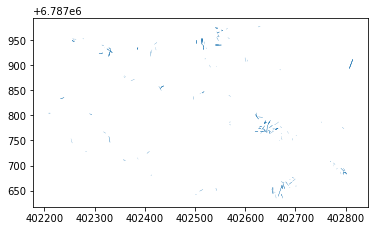

In [ ]:
new_fallen.plot()


In [ ]:
new_fallen.to_file('../../drone-tree-detection/filtered_fallen.shp')

In [ ]:
iou, ioa

(0.8055883510503123, 0.8476190476439849)

<AxesSubplot:>

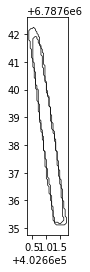

In [ ]:
fallen.iloc[[0,24]].plot(facecolor='none', edgecolor='black', lw=0.7)